## Image Classification and CIFAR-10

---

### **1. Getting Started with Image Classification and CIFAR-10**

Welcome to **Project 04**! In this project, we move beyond tabular datasets and enter the rich world of **image data**.

Our task is to build a neural network that can classify small color images from the **CIFAR-10** dataset. This is a classic problem in deep learning and computer vision.

> **🧠 What Is Image Classification?**

**Image classification** is the process of assigning a **label** to an image based on its content. For example:

- An image of a 🐸 → class: `"frog"`
- An image of a 🚗 → class: `"automobile"`

Unlike previous datasets where each row represented structured features (e.g., age, income), images are **grids of pixel values**. That makes things both interesting and challenging.

> **🗂️ The CIFAR-10 Dataset** : Source: https://www.cs.toronto.edu/~kriz/cifar.html

We’ll use the popular **CIFAR-10** dataset:
- 📦 60,000 color images of shape **32×32 pixels**
- 🎯 10 classes — each image belongs to one of these: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

- 🔀 Split into 50,000 training images and 10,000 test images
- 🎨 Each image has 3 color channels: Red, Green, Blue (RGB)

The small size (32×32) makes CIFAR-10 ideal for quick experiments — but it’s still visually rich and challenging.

> First Look: Sample Images from CIFAR-10

Let’s now preview a few images from the dataset to get a feel for what the model will be working with.

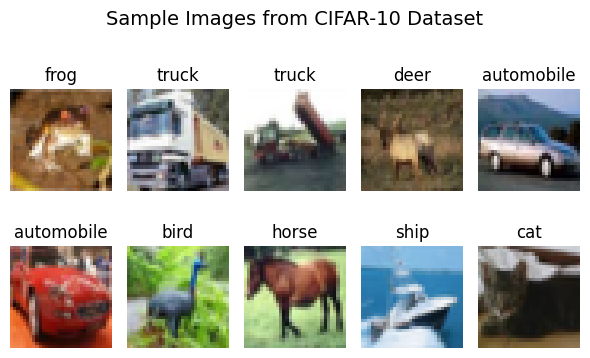

In [59]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Load CIFAR-10 training set (we’ll reuse this later too)
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get class names
class_names = train_dataset.classes

# Plot some random images
fig, axes = plt.subplots(2, 5, figsize=(6, 4))
for i in range(10):
    image, label = train_dataset[i]
    ax = axes[i//5, i%5]
    ax.imshow(image.permute(1, 2, 0))  # convert CHW to HWC
    ax.set_title(class_names[label])
    ax.axis('off')
plt.suptitle("Sample Images from CIFAR-10 Dataset", fontsize=14)
plt.tight_layout()
plt.show()

**Check Class Distribution**

Before training any model, it’s important to check if the dataset is **balanced** — i.e., roughly an equal number of  samples per class.

Unbalanced datasets can bias the model toward frequent classes and lead to poor performance on rare classes.

Let’s count how many images exist per class in the training set.

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


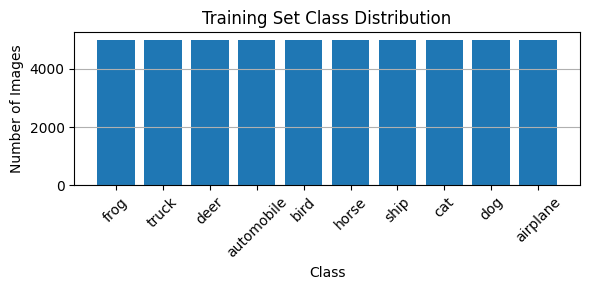

In [60]:
from collections import Counter

# Extract labels from the dataset
labels = [label for _, label in train_dataset]

# Count occurrences of each class
class_counts = Counter(labels)

# Convert to class name keys
class_counts_named = {class_names[k]: v for k, v in class_counts.items()}
print(class_counts_named)

# Plot
plt.figure(figsize=(6, 3))
plt.bar(class_counts_named.keys(), class_counts_named.values())
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


>What Do We See?

- All classes have **exactly 5000 images** — CIFAR-10 is **perfectly balanced**.
- This is great for training because we don’t need to worry about **class imbalance corrections** (for now).

It sets expectations for how a model **should perform** across all classes. If we later observe that some classes perform poorly, it’s **not due to lack of examples** — but perhaps due to class similarity or visual ambiguity.


>**Now, why Neural Networks?**

Image classification is **not trivial** — even small 32×32 images contain thousands of pixel values.

Some challenges:
- Each image has **3 color channels** (RGB)
- Each class varies in **shape, color, orientation**
- There's **no fixed feature set** like age or income

We need models that can learn directly from raw pixel inputs, discover **patterns**, **textures**, **shapes** and handle **high-dimensional inputs**.

➡️ That’s why we turn to **Neural Networks** — especially **Convolutional Neural Networks (CNNs)** in future projects.


>🧭 Where Are We Headed?

In this notebook, we’ll:
1. Build a **simple MLP** to classify CIFAR-10 images
2. Learn how to **flatten images** for MLP input
3. Observe **performance limitations** of MLPs on image data
4. Reflect on **why we need CNNs** going forward


Let’s now dive into how these images are represented as tensors, and how pixel values are prepared for neural network input.

---

Now you are ready to **answer Multiple Choice Questions 4.1.1.1 - 4.1.1.5**

---

**✅ Code Task 4.1.1.1 – Count Training Samples per Class**

📘 Goal: 
Count the number of samples for each class in the CIFAR-10 training dataset and print them with class names. This will help confirm class balance in the dataset.

(Reminder: All variables for tasks use CT_ prefix to avoid conflicts.)

In [61]:
from collections import Counter

# Step 1: Extract labels from the training dataset
labels = [label for _, label in train_dataset]

# Step 2: Count occurrences of each label index
CT_class_counts = Counter(labels)

# Step 3: Map indices to class names
# (Assuming train_dataset is a torchvision.datasets.ImageFolder)
CT_class_counts_named = {}
for idx, count in CT_class_counts.items():
    class_name = train_dataset.classes[idx]
    CT_class_counts_named[class_name] = count

# Step 4: Print counts
print("CT_Class Counts:")
for name, count in CT_class_counts_named.items():
    print(f"{name}: {count}")


CT_Class Counts:
frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


---

In [62]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1105512918", h="3298dbabb7", width=700, height=450)

### **2. Understanding Image Tensors and Pixel Normalization**

Before we can feed images into a neural network, we need to understand how image data is structured and why we normalize pixel values.

Let’s inspect a sample image from the CIFAR-10 training set and walk through the **shape and structure** of image tensors, how images are **converted to PyTorch tensors** and what happens to **pixel values** during this transformation

>**Image Structure: From Pixels to Tensors**

Each CIFAR-10 image is stored as a **3-dimensional array** representing:
- **3 channels**: Red, Green, Blue (RGB)
- Each channel is a **32×32 matrix** of pixel values

So the shape of an image tensor is:  **[Channels, Height, Width] = [3, 32, 32]**

When we use `transforms.ToTensor()`, the raw image pixels — originally in the range **[0, 255]** — are automatically scaled to **[0.0, 1.0]**.  
This is a form of **min-max normalization**, and it's crucial for training neural networks.

> Why Do We Normalize?

- Neural networks learn **faster** when inputs are on a **consistent scale**  
- **Unnormalized data** can cause unstable gradients, especially with large pixel values  
- **Normalized inputs** lead to **smoother convergence** and **better training stability**

> 🧮 **Min-Max Scaling: General Formula**

To scale input features into the range \([0, 1]\), we use the general min-max normalization formula:

$$
x_{\text{scaled}} = \frac{x_{\text{raw}} - x_{\min}}{x_{\max} - x_{\min}}
$$

Where:

- $x_{\text{raw}}$ is the original pixel value  
- $x_{\min}$, $x_{\max}$ are the minimum and maximum possible pixel values

For images with pixel values in the range [0, 255] (which is the case in our current context): $$x_{\text{scaled}} = \frac{x_{\text{raw}} - 0}{255 - 0} = \frac{x_{\text{raw}}}{255}$$

So, a pixel value of 0 becomes 0.0, and 127 becomes approximately 0.498, whereas 255 becomes 1.0.

Let’s confirm this by inspecting a real image from the dataset:

In [63]:
# Get one image and its label
image, label = train_dataset[0]

print(f"✅ Image tensor shape: {image.shape}  # Should be [3, 32, 32]")
print(f"✅ Class index: {label}")
print(f"✅ Class name: {class_names[label]}")
print(f"✅ Min pixel value: {image.min():.4f}")
print(f"✅ Max pixel value: {image.max():.4f}")

✅ Image tensor shape: torch.Size([3, 32, 32])  # Should be [3, 32, 32]
✅ Class index: 6
✅ Class name: frog
✅ Min pixel value: 0.0000
✅ Max pixel value: 1.0000


> Note for CNNs (Later Projects)

In future projects with **CNNs** and **pretrained models**, we’ll often use **standardization** instead of just min-max scaling.  That involves **subtracting the channel-wise mean** and **dividing by the standard deviation**: $$ x_{\text{standardized}} = \frac{x - \mu}{\sigma}$$

Where, $\mu$ is the **mean pixel value** (per channel) and $\sigma$ is the **standard deviation** (per channel). This further **centers the data** and improves **training dynamics** for deep CNNs.

---

Now you are ready to **answer Multiple Choice Questions 4.1.2.1 - 4.1.2.5**

---

**✅ Code Task 4.1.2.1 – Inspect a Single Image Tensor**

📘 Goal: Access one image tensor, print its shape, pixel value range, and corresponding class name. Helps students confirm tensor structure and scaling.

In [64]:
# Task – Inspect single image tensor

# Step 1: Access first sample
CT_image, CT_label =train_dataset[0]

# Step 2: Print properties
print("CT_Image shape:",CT_image.shape)       # Expect [3, 32, 32]
print("CT_Min pixel value:", float(CT_image.min()))
print("CT_Max pixel value:", float(CT_image.max()))
print("CT_Label index:", CT_label)
print("CT_Label name:",class_names[label])


CT_Image shape: torch.Size([3, 32, 32])
CT_Min pixel value: 0.0
CT_Max pixel value: 1.0
CT_Label index: 6
CT_Label name: frog


---

### **3. Flattening Images**

Our CIFAR-10 images are in shape **[3, 32, 32]**, meaning 3 color channels (RGB), each with a 32×32 grid of pixel values. However, basic neural networks (like the MLP we’ll build soon) accept **1D input vectors** — not 2D/3D structures.

Out Goal here is to convert each image from shape: [C, H, W] = [3, 32, 32] to a flat vector of shape: [3072] = 3 × 32 × 32

This process is known as **flattening** or **vectorization**.

**Visual Example**

Let’s visualize what flattening does to a small image:

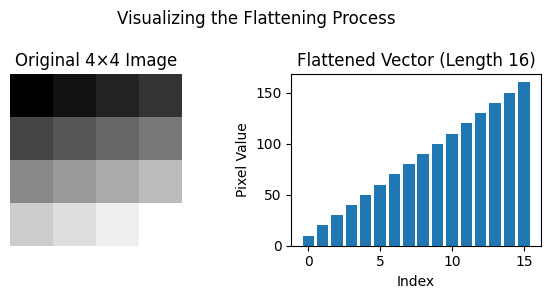

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate a grayscale 4x4 image (1 channel)
image = np.array([
    [10, 20, 30, 40],
    [50, 60, 70, 80],
    [90, 100, 110, 120],
    [130, 140, 150, 160]
])

# Flatten it
flattened = image.flatten()


# Plot original and flattened
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original 4×4 Image")
axs[0].axis('off')

axs[1].bar(np.arange(len(flattened)), flattened)
axs[1].set_title("Flattened Vector (Length 16)")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Pixel Value")

plt.suptitle("Visualizing the Flattening Process")
plt.tight_layout()
plt.show()

**Lets keep in mind that**, flattening **destroys spatial structure** (e.g., neighborhood relationships between pixels). CNNs handle this better — we’ll explore that in later projects. For now, we’re using MLPs, so flattening is necessary.

Now let's flatten one image:

In [66]:
# Fetch one sample
image, label = train_dataset[0]
print(f"Original shape: {image.shape}")  # [3, 32, 32]

# Flatten the image
flattened = image.view(-1)  # or image.reshape(-1)
print(f"Flattened shape: {flattened.shape}")  # [3072]
flattened

Original shape: torch.Size([3, 32, 32])
Flattened shape: torch.Size([3072])


tensor([0.2314, 0.1686, 0.1961,  ..., 0.5490, 0.3294, 0.2824])

The `.view(-1)` method in PyTorch reshapes the image tensor to a **1D vector**. This is what we’ll feed into a fully connected layer of an MLP.

Just to share, we can also **reshape** the 1D vector back into an image format: `reshaped = flattened.view(3, 32, 32)`. Useful for debugging or visual checks!

> **❗️ But Wait — We Must Flatten the Entire Dataset**

Flattening just one image for demo purposes is not enough. We need to make sure that all training, validation, and test images are automatically flattened before being passed to the model.

**✅ Solution: Update the Transform Pipeline**

Let’s redefine our transform to convert image to tensor as well as to flatten it to a 1D vector.

In [67]:
import torchvision.transforms as transforms

# New transform: ToTensor + Flatten
transform = transforms.Compose([
    transforms.ToTensor(),                            # [3, 32, 32], scaled to [0,1]
    transforms.Lambda(lambda x: x.view(-1))           # Flatten to [3072]
])


**🔁 Reload Datasets with Flattening Transform**

In [68]:
from torchvision.datasets import CIFAR10

# Reload with new transform
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)


>Next Up:

Now that we’ve flattened images, let’s normalize pixel values — another vital preprocessing step that makes training faster and more stable.

---

Now you are ready to **answer Multiple Choice Questions 4.1.3.1 - 4.1.3.3**

---

**✅ Code Task 4.1.3.1 – Verify Flattening of Image**

📘 Goal: Flatten one CIFAR-10 image tensor (3×32×32 → 3072) and confirm new shape. This checks understanding of flattening step for MLP input.

In [69]:
CT_image_flat, CT_label_flat = train_dataset[0]


# Step 2: Flatten the image manually
CT_flattened = CT_image_flat.view(-1)

# Step 3: Print original and flattened shapes
print("CT_Original shape:", CT_image_flat.shape)    # Expect torch.Size([3, 32, 32])
print("CT_Flattened shape:", CT_flattened.shape)

CT_Original shape: torch.Size([3072])
CT_Flattened shape: torch.Size([3072])


---

### **4. Prepare DataLoaders — Train, Validation, and Test**

Now that our **CIFAR-10** dataset is loaded and normalized, we’ll use **PyTorch DataLoaders** to prepare it for training.

>`torch.utils.data.DataLoader` helps with efficient and flexible data loading by:

- **Batching**: Feeds small groups of images (e.g., 64) at each training step
- **Shuffling**: Randomizes the order of samples each epoch to improve generalization
- **Parallel Loading**: Uses multiple workers to load data faster in the background

CIFAR-10 provides us with: **50,000 training images** and **10,000 test images**

We'll further split the **training set** into **45,000 for training** and **5,000 for validation**

>✅ Why This Split?

- **Training set (45K)**: Used to train the model (weights updated here)
- **Validation set (5K)**: Used during training to monitor performance and detect overfitting
- **Test set (10K)**: Held out until the end for final unbiased evaluation

> Using separate validation and test sets allows us to monitor model behavior during training without contaminating our final performance estimate.

In [70]:
import torch
from torch.utils.data import DataLoader, random_split

# Set seed for reproducibility
torch.manual_seed(42)

# Define batch size
batch_size = 64

# Optionally split train dataset into train + validation (e.g., 45k train, 5k val)
train_size = int(0.9 * len(train_dataset))  # 45,000
val_size = len(train_dataset) - train_size  # 5,000

train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Wrap in DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check sizes
print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Validation batches: {len(val_loader)}")
print(f"✅ Test batches: {len(test_loader)}")


✅ Train batches: 704
✅ Validation batches: 79
✅ Test batches: 157


In [76]:
# check the shape of of an image and label in the first batch
for images, labels in train_loader:
    print(f"✅ Batch shape: {images.shape}")  # Should be [batch_size, 3072]
    print(f"✅ Labels shape: {labels.shape}")  # Should be [batch_size]
    break  # Just check the first batch

✅ Batch shape: torch.Size([64, 3072])
✅ Labels shape: torch.Size([64])


➡️ Next, we’ll build a **Simple MLP architecture** to classify these images using the CIFAR-10 labels.

---

Now you are ready to **answer Multiple Choice Questions 4.1.4.1 - 4.1.4.4**

---

**✅ Code Task 4.1.4.1 – Check DataLoader Batch Shapes**

📘 Goal: Fetch one batch from train_loader and print shape of features and labels to verify batching logic (64 × 3072 for features, 64 for labels).

In [77]:
CT_images_batch, CT_labels_batch = next(iter(train_loader))
print("CT_Batch feature shape:", CT_images_batch.shape)
print("CT_Batch label shape:", CT_labels_batch.shape)


CT_Batch feature shape: torch.Size([64, 3072])
CT_Batch label shape: torch.Size([64])


---

### **5. Define a Simple MLP for CIFAR-10**

We’ll now define our **first neural network** — a basic MLP (Multilayer Perceptron).

>MLP Structure

We flattened each 32×32 RGB image into a **3072-dimensional vector**.

Here’s our architecture:

- **Input layer**: 3072 units (32×32×3)
- **Hidden layer**: 128 units + ReLU
- **Output layer**: 10 units (logits, one per class)

This is a **fully connected network** — each neuron connects to every unit in the next layer.

We start with MLP to understand baseline performance — **before introducing CNNs** (which are better suited for images). You’ll soon see why.

In [73]:
import torch.nn as nn

# Define the MLP class
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=128, output_dim=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
mlp_model = SimpleMLP()

# Print model summary
print(mlp_model)


SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


>What Does This Model Do?

- First `Linear` layer transforms 3072 → 128
- `ReLU` adds non-linearity to learn complex patterns
- Final `Linear` outputs 10 logits, which are used by CrossEntropyLoss

>Important Notes

- We don’t use `Softmax` in the model — because `nn.CrossEntropyLoss` internally applies it.
- We'll **track both training loss and accuracy** as we proceed.

➡️ In the next section, we’ll train this model using **CrossEntropyLoss** and check how well it learns on CIFAR-10.

---

Now you are ready to **answer Multiple Choice Questions 4.1.5.1 and 4.1.5.2**

---

### **6. Training the MLP on CIFAR-10**

We now train our `SimpleMLP` using:

- **Loss**: `CrossEntropyLoss`, ideal for multiclass classification.
- **Optimizer**: `Adam`, a widely used optimizer combining momentum and adaptive learning rates.
- **Epochs**: We'll train for a few epochs and observe the trends in loss and accuracy.

**Key Concepts**

**Loss Function**: We use `nn.CrossEntropyLoss` which combines **log-softmax** and **negative log-likelihood**. It expects raw logits as model output and integer class labels as targets

**Optimizer**: We use `Adam` for efficiency and stability. We'll update weights based on gradients computed by backpropagation.

**Metrics**: We’ll track **Training loss** (average per epoch) and **Training accuracy** (proportion of correct predictions).

In [74]:
import torch.optim as optim

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Tracking
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # No need to flatten here — already done via transform
        # images = images.view(images.size(0), -1)  # ← would be needed if not pre-flattened

        # Forward pass
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Epoch summary
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")


Epoch [1/10] - Loss: 1.8911 | Accuracy: 0.3200
Epoch [2/10] - Loss: 1.7244 | Accuracy: 0.3843
Epoch [3/10] - Loss: 1.6642 | Accuracy: 0.4077
Epoch [4/10] - Loss: 1.6239 | Accuracy: 0.4210
Epoch [5/10] - Loss: 1.5954 | Accuracy: 0.4326
Epoch [6/10] - Loss: 1.5746 | Accuracy: 0.4374
Epoch [7/10] - Loss: 1.5540 | Accuracy: 0.4444
Epoch [8/10] - Loss: 1.5453 | Accuracy: 0.4504
Epoch [9/10] - Loss: 1.5292 | Accuracy: 0.4537
Epoch [10/10] - Loss: 1.5224 | Accuracy: 0.4581


After 10 epochs, here’s what we observed:

- **Initial loss**: 1.89 → **Final loss**: 1.52
- **Accuracy improved** from **32% to ~46%** over the epochs

The model is **learning steadily** — loss is decreasing and accuracy is improving. But performance is still **far from ideal**. With **only one hidden layer** and **no spatial awareness**, it’s expected that:

  - The MLP **struggles to capture image structure** (e.g., edges, shapes, textures)
  - It **treats pixels as independent features**, which is suboptimal for images
  - The model is **underfitting**, though improving

>🔧 What Can Help?

- **Deeper MLPs** (more hidden layers)
- **Better optimizers or learning rate tuning**
- **Convolutional Neural Networks (CNNs)** — designed to leverage **spatial locality**

➡️ In the next section, we’ll **evaluate this model on the test set** using accuracy and a **confusion matrix**, to understand **which classes it gets right or wrong**.

---

**✅ Code Task 4.1.6.1 – One Training Epoch on CIFAR-10**

📘 Goal: Perform one training epoch on CIFAR-10 using the provided mlp_model, compute and print final epoch loss and accuracy. Reinforces training loop fundamentals.

In [84]:
# Task 5 – One training epoch

mlp_model.train()

CT_running_loss = 0.0
CT_correct = 0
CT_total = 0

for CT_images, CT_labels in train_loader:
    CT_images, CT_labels = CT_images.to(device), CT_labels.to(device)

    # Forward pass
    CT_outputs = mlp_model(CT_images)
    CT_loss =criterion(CT_outputs,CT_labels)

    # Backpropagation
    optimizer.zero_grad()
    CT_loss.backward()
    optimizer.step()

    # Accumulate stats
    CT_running_loss +=loss.item() * CT_images.size(0)
    _, CT_predicted = torch.max(CT_outputs, 1)
    CT_correct +=(CT_predicted==CT_labels).sum().item()
    CT_total +=CT_labels.size(0)

# Compute average loss and accuracy
CT_epoch_loss = CT_running_loss / CT_total
CT_epoch_acc = CT_correct / CT_total

print(f"CT_OneEpoch Loss: {CT_epoch_loss:.4f}")
print(f"CT_OneEpoch Accuracy: {CT_epoch_acc:.4f}")


CT_OneEpoch Loss: 1.4644
CT_OneEpoch Accuracy: 0.4635


---

### **7. Evaluation**

We will, now:

- Run the trained model on the test set.
- Compute test accuracy.
- Plot the confusion matrix.
- Interpret where the model succeeds or struggles.

✅ Test Accuracy: 0.4490


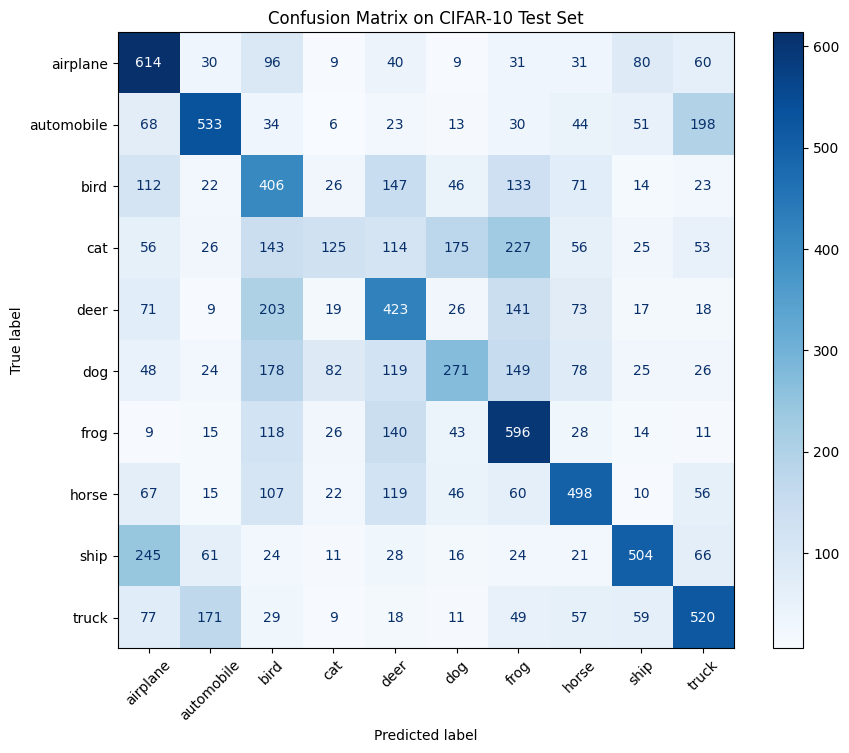

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Set model to eval mode
mlp_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        #images = images.view(images.size(0), -1).to(device)
        images = images.to(device)  # ✅ No need to flatten again
        labels = labels.to(device)

        outputs = mlp_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.show()


Each row of the matrix represents the **true class**, and each column the **predicted class**.  
The diagonal elements represent **correct predictions** — so higher values along the diagonal are desirable.

>🔍 What Can We Observe?

- The model correctly identifies certain classes well (e.g., **automobile**, **ship**, and **truck**), as seen by high diagonal values.
- **Bird**, **cat**, and **frog** have significantly more **off-diagonal confusion**, especially with each other — which is intuitive because they share visual similarities.
- **Ship** is often misclassified as **airplane**, likely due to shared backgrounds like sky or water in low-res images.
- **Truck** frequently gets confused with **automobile**, which makes sense given both are vehicles.

>⚠️ Key Takeaways

- **Accuracy is not the whole story**: We see that some classes (like `dog`, `cat`, `bird`) suffer more than others.
- **Model struggles with subtle visual distinctions** between classes — a key limitation of **MLPs** when applied to images.
- **Spatial information is lost** when we flatten the image into a 1D vector.

➡️ In the next section, we’ll discuss **why MLPs struggle with image data**, and how **convolutional architectures** (covered soon!) are designed to address these exact issues.

---

### **8. Why MLPs Struggle with Image Data**

Even after training a fully connected neural network (MLP) on CIFAR-10:
- Accuracy plateaued around **45–46%**.
- Confusion matrix showed **lots of misclassifications**, especially for visually similar categories.
- Some classes (e.g., `ship`, `truck`) did relatively well, while others (like `bird`, `cat`) performed poorly.

>**But Why?**

**1. 🧱 Loss of Spatial Structure**

MLPs require us to **flatten images** into long 1D vectors.

- A 32×32 color image becomes a **3072-length vector** (32 × 32 × 3).
- All **spatial relationships** between neighboring pixels are **destroyed**.
- This makes it harder for the model to learn **local patterns** (e.g., edges, corners, textures).

The model sees no 2D structure — just a long list of numbers.

**2. 📏 Too Many Parameters**

Because every pixel is connected to **every neuron**, the number of parameters explodes:

- For a simple MLP with 3072 inputs and a hidden layer of 256 neurons:
  → **3072 × 128 = 3,93,216 weights** in the first layer alone!

This leads to **High memory usage**, **Overfitting risk** (especially with limited data), and **Slower convergence** during training.

**3. 🚫 No Inductive Bias**

MLPs have **no built-in assumptions** about images. They treat all input features (pixels) as equally important, regardless of **position** or **locality**.

Contrast this with:
- **Convolutional Neural Networks (CNNs)**, which:
  - Exploit local patterns (like edges, textures)
  - Share weights (via kernels)
  - Have fewer parameters
  - Learn hierarchical representations

**What We'll Do Next**

To address these challenges, in upcoming notebooks we'l try **deeper MLPs** to understand how depth helps (a little). Then we will **introduce CNNs**, which are designed **specifically for image data** and will learn how CNNs preserve spatial structure while reducing parameter count.

➡️ In the next notebook, we’ll try to improve things by going **deeper** — adding more layers to our MLP and using better training tricks.

---

Now you are ready to **answer Multiple Choice Question 4.1.8.1**

---